# Lab Assignment Seven: RNNs

### Luis Garduno

Dataset : [Sentiment140 Kaggle Dataset](https://www.kaggle.com/kazanova/sentiment140) 

----------------------------

## 1. Preparation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Data Preparation

In [8]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tkinter import Tcl
from skimage.io import imshow
from sklearn import metrics as mt
from sklearn import preprocessing

%matplotlib inline

le = preprocessing.LabelEncoder()

# Load in Sentiment140 Dataset in pandas array
df = pd.read_csv('../data/Sentiment140/training.1600000.processed.noemoticon.csv',
                 names=['polarity', 'id', 'date', 'query', 'user', 'tweet'],
                 encoding='ISO-8859-1')

# Create sample (Remove later)
df = df.sample(frac=1)
df = df[:200000]

print("Number of Total Tweets:", len(df), "\n")

# Check if our dataset is missing any columns
df.info()

Number of Total Tweets: 200000 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 256019 to 1386497
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  200000 non-null  int64 
 1   id        200000 non-null  int64 
 2   date      200000 non-null  object
 3   query     200000 non-null  object
 4   user      200000 non-null  object
 5   tweet     200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


| Field | Description | Type |
| ----- | ----------- | ---- |
| **Polarity** | &nbsp;&nbsp;&nbsp; - The target/polarity of the tweet <br /> &nbsp;&nbsp; [0] Negative; [2] Neutral; [4] Positive; | Discrete |
| **id**    | &nbsp;&nbsp;&nbsp; - The id of the tweet    | Discrete |
| **date**  | &nbsp;&nbsp;&nbsp; - The date of the tweet  | Interval |
| **query** | &nbsp;&nbsp;&nbsp; - The query | Nominal |
| **user**  | &nbsp;&nbsp;&nbsp; - The user that tweeted  | nominal  |
| **tweet**  | &nbsp;&nbsp;&nbsp; - The text of the tweet  | nominal  |

In [2]:
# Find unique values within each field, before dropping columns.
df.nunique()

polarity         2
id          199985
date        174990
query            1
user        148231
tweet       199185
dtype: int64

After outputting all of the unique values, we see that there is only 1 unique value
within the query field, meaning that it will not make an impact when further doing
our analysis because all the values are the same. Other fields that can be dropped
are the user tweet id, username, iand date because these these do not impact whether a
user's tweet is negative or positive.

Addtionally we're able to see that there's 2 unique values within the polarity field,
it is probably best to find out what these two values are and change them so that 0
equals negative and 1 equals positive.

In [4]:
# Drop the fields we don't need
df.drop(['id', 'date', 'query','user'], axis=1, inplace=True)

# Find the 2 unique polarity fields
df['polarity'].unique()

array([4, 0])

Number of Total Tweets: 200000 



Text(0, 0.5, 'Number of Tweets')

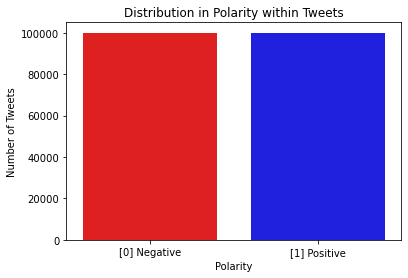

In [6]:
# Change [4] to [1] so the data is easier to understand.
df['polarity'] = df['polarity'].replace(4,1)

# Visualize whether data is evenly divided in terms of the polarity of tweets.
ax = sns.countplot(x="polarity", data=df, palette=['red', 'blue'])
ax.set_title('Distribution in Polarity within Tweets')
ax.set_xlabel('Polarity')
ax.set_xticks([0,1])
ax.set_xticklabels(['[0] Negative', '[1] Positive'])
ax.set_ylabel('Number of Tweets')

In [12]:
# Check for proper variable representations
df['tweet'] = df['tweet'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 256019 to 1386497
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  200000 non-null  int64 
 1   id        200000 non-null  int64 
 2   date      200000 non-null  object
 3   query     200000 non-null  object
 4   user      200000 non-null  object
 5   tweet     200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


Duplicates :  0


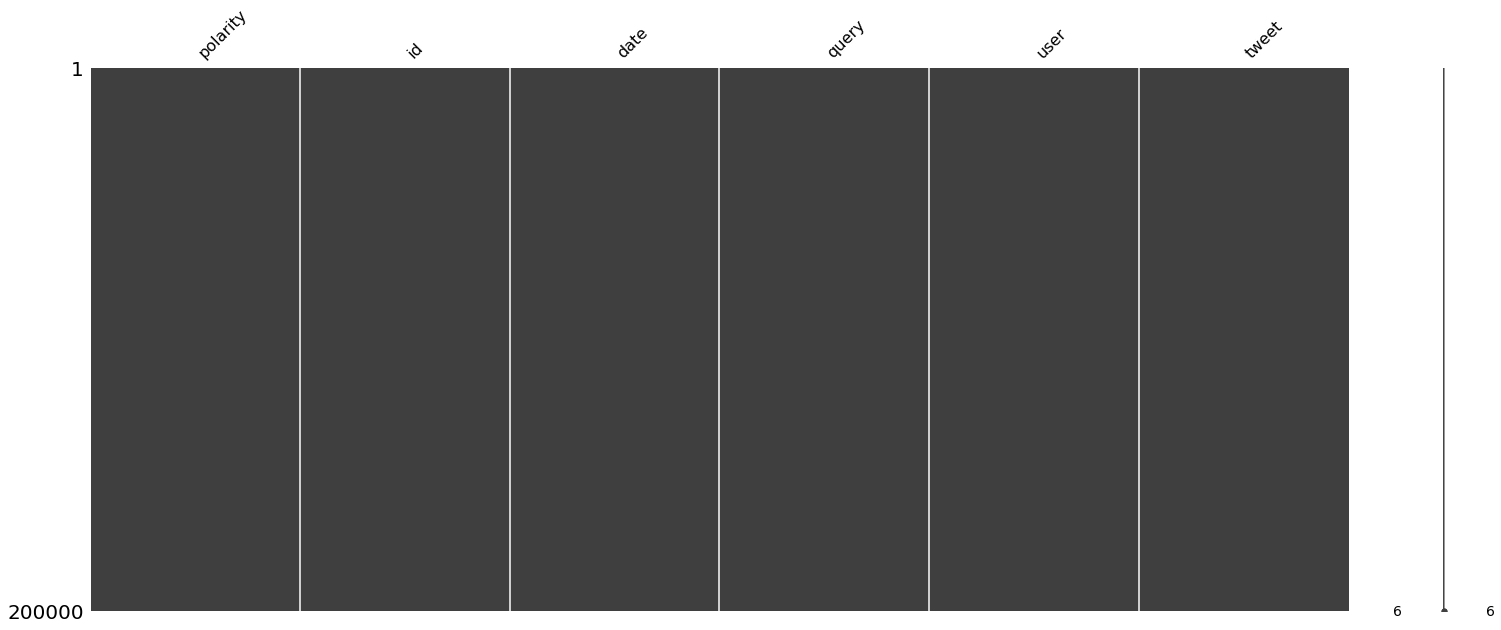

In [11]:
import missingno as mn

# Check for any missing/null values within remainder of data
mn.matrix(df)

df_miss = df.replace(to_replace=-1,value=np.nan)
df_miss = df_miss.duplicated()
print('Duplicates : ', len(df[df_miss]))

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Text Preprocessing

In [ ]:
# We begin by applying the common text-pre-processing practices such as:
# removing stop_words, stemming words, lemmatize words, and tokenize individual words

In [16]:
import nltk
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('stopwords')
nltk.download('punkt')

stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/blurry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/blurry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- Describe the final dataset that is used for classification/regression (include a description of any newly formed variables I created).

For my final dataset that I will be using for my classification problem, in regards of
predicting whether a tweet is positive or negative, I selected to use only 2 columns:
- Polarity : Whether a tweet in negative or positive ([0] negative; [1] Positive;)
- Tweet : The text of a given tweet 


- Discuss methods of tokenization in my dataset as well as any decisions to force a specific length of sequence.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Choosing a Metric (20%)

In [ ]:
# - Choose & explain what metric(s) I'll use to evaluate my algorithm’s performance.

As for metrics, for this specific classification problem, it is very easy to
know that I will be using accuracy as a metric to determine the correctness of
of the algorithm. It will use binary cross entropy as it's loss function given
the values of the polarity column are 0 and 1.

- I should give a detailed argument for why this (these) metric(s) are appropriate on my data.
- That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task).
- Please note: rarely is accuracy the best evaluation metric to use.
    - Think deeply about an appropriate measure of performance.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.4 Creating Training & Testing Data (30%)

In [ ]:
# - Choose the method I'll use for dividing my data into training and testing (i.e., am I  using Stratified 10-fold cross validation? Shuffle splits? Why?).
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2)

- Explain why my chosen method is appropriate or use more than one method as appropriate.
- Convince me that my cross validation method is a realistic mirroring of how an algorithm would be used in practice.

-----------------------------

## 2. Modeling | You're @ a C, keep going bro.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Exploring Recurrent Network Architectures

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.1 Method 1: GRU Architecture (45%)

A Gated Recurrent Network, or GRU
- Be sure to use an embedding layer (pre-trained, from scratch, OR both).
- Adjust hyper-parameters of the networks as needed to improve generalization performance.

In [ ]:
#################################################################################
######################## RNN Style Architecture : GRU [1] #######################
#################################################################################

# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

class myCallback(keras.callbacks.Callback):
def on_epoch_end(self,epoch,logs=()):
    train_loss = logs.get('loss')
    val_loss = logs.get('val_loss')
    if val_loss - train_loss > 0.2:
      print('Loss on validation set is much higher than training set. Training cancelled')
      self.model.stop_training=True


def build_model(vocab_size,embedding_dim,max_length):
model = keras.models.Sequential([
          Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                   weights=[embeddings_matrix],
                   trainable=False),
          Bidirectional(LSTM(64,dropout=0.3,return_sequences=True)),
          Dropout(0.3),
          Bidirectional(LSTM(64,dropout=0.3)),
          Dropout(0.3),
          Dense(512,activation='relu'),
          Dropout(0.3),
          Dense(1,activation='sigmoid')])
      
  model.compile(optimizer=keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['acc'])
  return model

In [ ]:
# Be sure to use an embedding layer (pre-trained, from scratch, OR both).
# Adjust hyper-parameters of the networks as needed to improve generalization performance.

##### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2.2 Method 2: LTSM  Architecture (60%)

A "long short-term memory" units, or LTSM

In [ ]:
##################################################################################
######################## RNN Style Architecture : LTSM [1] #######################
##################################################################################


# - Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# - The input to the second chain should be the output sequence of the first chain.


In [ ]:
##################################################################################
######################## RNN Style Architecture : LTSM [2] #######################
##################################################################################


# - Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# - The input to the second chain should be the output sequence of the first chain.


- Discuss the performance of each network & compare them.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Adding a 2nd recurrent chain (70%) | You're at a C+!!!

In [ ]:

# Using the best RNN parameters & architecture, add a second recurrent chain to my RNN.
# The input to the second chain should be the output sequence of the first chain.
# Visualize the performance of training & validation sets versus the training iterations.


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Using Cross Validation (90%) Bro, all you need is 15/20pts. Final Stretch!

In [ ]:

# - Use the method of cross validation & evaluation criteria that I argued for at the beginning of the lab.


In [ ]:

# - Visualize the results of all the RNNs I trained.


In [ ]:

# Use proper statistical comparison techniques to determine which method(s) is (are) superior.


----------------------------------------

### 3. t-SNE or RNN generating novel text
You have free reign to provide additional analyses. Ideas:

- Option 1: Use t-SNE (or SVD or PCA or UMAP) to visualize the word embeddings of a subset of words in your vocabulary.
    - Try to interpret what each dimension reflects (in your own words).
    - That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding.

- Options 2: Use the ConceptNet Numberbatch embedding & compare to GloVe

- Another Idea (NOT required): Try to create a RNN for generating novel text.

#### Reference